### Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import FashionMNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:17<00:00, 1.54MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 609kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 10.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.83MB/s]


Text(0.5, 1.0, 'Image label: 8')

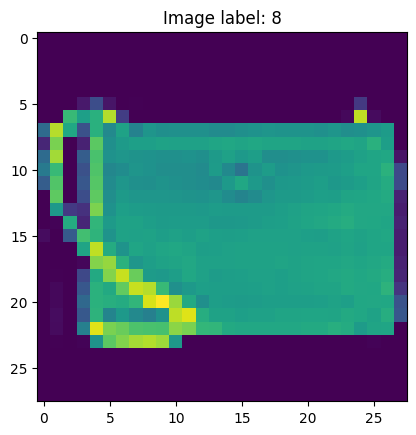

In [3]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [4]:
# Создание модели
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [32, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [32, 64, 7, 7]
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = FashionMNISTModel()
model.to(device)

# Обучение модели
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    # Валидация
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_preds.append(outputs.argmax(dim=1).cpu())
            val_labels.append(labels.cpu())
    
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)
    val_acc = (val_preds == val_labels).float().mean()
    
    train_loss = train_loss / len(train_data_loader.dataset)
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')
    scheduler.step(val_acc)

# Проверка точности на тестовом наборе
model.eval()
predicted_labels = []
real_labels = []
with torch.no_grad():
    for batch in test_data_loader:
        images, labels = batch[0].to(device), batch[1]
        outputs = model(images)
        predicted_labels.append(outputs.argmax(dim=1).cpu())
        real_labels.append(labels)

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).float().mean()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/15 | Train Loss: 0.4713 | Val Acc: 0.8778
Epoch 2/15 | Train Loss: 0.3060 | Val Acc: 0.8923
Epoch 3/15 | Train Loss: 0.2631 | Val Acc: 0.9023
Epoch 4/15 | Train Loss: 0.2343 | Val Acc: 0.9078
Epoch 5/15 | Train Loss: 0.2102 | Val Acc: 0.9145
Epoch 6/15 | Train Loss: 0.1882 | Val Acc: 0.9152
Epoch 7/15 | Train Loss: 0.1735 | Val Acc: 0.9140
Epoch 8/15 | Train Loss: 0.1570 | Val Acc: 0.9181
Epoch 9/15 | Train Loss: 0.1445 | Val Acc: 0.9160
Epoch 10/15 | Train Loss: 0.1308 | Val Acc: 0.9165
Epoch 11/15 | Train Loss: 0.1223 | Val Acc: 0.9183
Epoch 12/15 | Train Loss: 0.1126 | Val Acc: 0.9221
Epoch 13/15 | Train Loss: 0.1064 | Val Acc: 0.9211
Epoch 14/15 | Train Loss: 0.0963 | Val Acc: 0.9224
Epoch 15/15 | Train Loss: 0.0925 | Val Acc: 0.9216
Test Accuracy: 0.9216


Не забудьте перенести модель на выбранный `device`!

Локальные тесты для проверки вашей модели доступны ниже:

In [5]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, "Please, use `model` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
# your code here

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [6]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].to(device))
        predicted_labels.append(y_predicted.argmax(dim=1).cpu())
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [7]:
print(f"Neural network accuracy on train set: {train_acc:3.5}")

Neural network accuracy on train set: 0.98002


In [8]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].to(device))
        predicted_labels.append(y_predicted.argmax(dim=1).cpu())
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [9]:
print(f"Neural network accuracy on test set: {test_acc:3.5}")

Neural network accuracy on test set: 0.9216


Проверка, что необходимые пороги пройдены:

In [10]:
assert test_acc >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

### Сдача задания
Загрузите файл `hw10_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки.

In [14]:
# do not change the code in the block below
# __________start of block__________
import os
import json


assert os.path.exists(
    "hw10_data_dict.npy"
), "Please, download `hw10_data_dict.npy` and place it in the working directory"


def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels_np = torch.cat(predicted_labels).numpy()
    predicted_labels_str = ",".join([str(x) for x in list(predicted_labels)])
    return predicted_labels_np, predicted_labels_str


loaded_data_dict = np.load("hw10_data_dict.npy", allow_pickle=True)

train_labels_np, train_labels_str = get_predictions(
    model, torch.FloatTensor(loaded_data_dict.item()["train"])
)
test_labels_np, test_labels_str = get_predictions(
    model, torch.FloatTensor(loaded_data_dict.item()["test"])
)

submission_dict_str = {
    "train": train_labels_str,
    "test": test_labels_str,
}

submission_dict_np = {
    "train": train_labels_np,
    "test": test_labels_np,
}

np.save("submission_dict_hw10.npy", submission_dict_np, allow_pickle=True)
with open("submission_dict_hw10.json", "w") as iofile:
    json.dump(submission_dict_str, iofile)
print("File saved to `submission_dict_hw10.json` and `submission_dict_hw10.npy`")
# __________end of block__________

File saved to `submission_dict_hw10.json` and `submission_dict_hw10.npy`


На этом задание завершено. Поздравляем!